# Bulk RNAseq Analysis Notebook

This Jupyter notebook provides a comprehensive workflow for analyzing bulk RNA-Seq data. This analysis includes differential expression analysis, gene enrichment analysis, and pathway analysis. The notebook is divided into several sections, each focusing on a specific aspect of the analysis.

The analysis utilized a prostate cancer dataset available at https://www.ncbi.nlm.nih.gov/sra?term=SRP060235.

### Data Import and Preprocessing
The notebook begins by importing the necessary libraries and loading the RNA-Seq count data and metadata. The count data is then preprocessed, which typically involves filtering out lowly expressed genes and normalizing the counts.

### Differential Expression Analysis
The next section of the notebook is dedicated to differential expression analysis. This involves comparing the expression levels of genes between two or more conditions (e.g., disease vs. control) to identify genes that are differentially expressed. The analysis is performed using the DESeq2 package, which models count data using negative binomial distribution and uses a shrinkage estimator for dispersion and fold change.

### Gene Enrichment Analysis
After identifying differentially expressed genes, the notebook proceeds to gene enrichment analysis. This analysis aims to identify biological processes or pathways that are over-represented in the set of differentially expressed genes. The analysis is performed using the clusterProfiler package, which supports several enrichment analysis methods and databases, including Gene Ontology (GO) and KEGG.

### Pathway Analysis
The final section of the notebook focuses on pathway analysis. This involves mapping the differentially expressed genes onto biological pathways to gain insights into the biological mechanisms underlying the observed changes in gene expression. The analysis is performed using the clusterprofiler package for KEGG pathway analysis.

### Visualization 
Each section of the notebook includes code for visualizing the results, such as MA plots for differential expression analysis, bar plots for gene enrichment analysis, and pathway diagrams for pathway analysis. Some results will be outputted to the `results` directory.

This notebook provides a comprehensive and flexible workflow for bulk RNA-Seq data analysis. It can be easily adapted to different datasets and research questions, making it a valuable tool for RNA-Seq data analysis.

# Load R packages and helper functions

In [1]:
# Load R packages
suppressPackageStartupMessages(source('src/main.R'));

### Set input files

- **gene_counts**: Path to gene count matrix file 

- **metadata**: Path to the sample metadata containing data relating to the samples (i.e condition, age, ethnicity, etc.)

In [2]:
gene_counts = "data/prostate_cancer_gene_count_matrix.csv"
metadata = "data/prostate_cancer_metadata.txt"

### Set parameters 
The notebook is parameterized so that if you do need to change any parameters, it is done in this section below. The changes below will then propogate to the rest of notebook and run with the parameters provided: 

- **p_value_cutoff**: p-value cutoff 
  
- **logFC_cutoff**: log Fold Change cutoff 

- **organism**: Name of organism you are looking for

- **kegg_organism**: Name of the organism to use for Kegg pathway analysis 

- **reactome_organism**: Name of the organism to use for Reactome pathway analysis 

- **wifiPathways_organism**: Name of the organism to use for wifiPathways pathway analysis 

**Note** the different organisms will need to change depending on the type of organism you are using. This will require you installing additional databases for this (i.e Bioconductor package **org.Hs.eg.db**)

In [3]:
# set parameters 
p_value_cutoff = 0.05
logFC_cutoff = 1.5

# Organism for Gene Enrichment Analysis (Human)
organism = "org.Hs.eg.db" 

# Parameters for Pathway Analysis (Human) 
kegg_organism = "hsa"
reactome_organism = "human" 
wikiPathways_organism = "Homo sapiens"

### Read and process data files

In [4]:
# Load and preprocess the count and metadata files
data <- read_and_preprocess(count_path = gene_counts, metadata_path = metadata)

# Differential Expression 

Differential expression analysis is a bioinformatics technique used to analyze data from high-throughput gene expression experiments, such as RNA sequencing (RNA-seq) or microarray experiments. The primary goal is to identify genes whose expression levels are significantly different between two or more biological conditions or groups.

For example, differential expression analysis might be used to compare gene expression levels in cancerous tissues versus normal tissues, or to compare the expression levels in cells under different treatment conditions.

Differential expression analysis helps to find:

1. **Differentially Expressed Genes (DEGs)**: These are genes that show statistically significant differences in expression levels between the groups being compared. DEGs might be up-regulated (higher expression) or down-regulated (lower expression) in one group compared to another.

2. **Biological Insights**: By identifying DEGs, researchers can gain insights into the biological processes that are active under different conditions. For example, if a particular gene is known to be involved in inflammation and is found to be up-regulated in a disease state, this could suggest that inflammation is a component of the disease.

3. **Molecular Targets for Therapeutics**: In medical research, DEGs can sometimes be potential targets for therapeutic intervention. For instance, a gene that is overexpressed in cancer cells but not in normal cells might be a target for drugs.

4. **Understanding Genetic Mechanisms**: Differential expression analysis can also help in understanding the genetic mechanisms underlying various biological phenomena and diseases.

5. **Biomarkers**: Genes that are differentially expressed in a particular disease state compared to a normal state might serve as biomarkers for disease diagnosis, prognosis, or monitoring.

In order to perform differential expression analysis, statistical methods are used to determine whether the differences in gene expression are significant. These methods take into account the variability in gene expression and correct for multiple hypothesis testing. Here we use DESeq2. 


In [5]:
# run differential expression analysis using DESeq2
dds <- differential_expression(data$count_matrix, data$coldata)

### Results of DESeq2 
The first thing that is outputted gives you a summary of the results of DESeq2. It will give you percentage of up/down regulated genes, outliners, and low counts based off the p-value cutoff you provided. 

The table displayed by the code next, will allow a user to interactively explore the differentially expressed genes in your dataset. Using the search bar you can look at particular genes of interest. 

1. **"GeneID" or "gene_name"**: These columns typically contain the unique identifiers or names of the genes being analyzed.

2. **"baseMean"**: This column represents the average of normalized counts across all samples for a given gene. It provides an estimate of the overall expression level of the gene.

3. **"log2FoldChange"**: This column contains the logarithmic fold change values, which represent the difference in expression between two groups. Positive values indicate upregulation in the test group, while negative values indicate downregulation.

4. **"lfcSE"**: The log2 fold change standard error (SE) column represents the standard error associated with the log2 fold change estimate. It provides information about the uncertainty of the fold change measurement.

5. **"stat"**: This column represents the Wald statistic, which is computed as the ratio of the estimated log2 fold change to its standard error. It is used in hypothesis testing to assess the significance of differential expression.

6. **"pvalue"**: The p-value column contains the p-values associated with each gene, indicating the statistical significance of differential expression. A lower p-value suggests stronger evidence for differential expression.

7. **"padj"**: The adjusted p-value column (often denoted as "padj" or "adjusted p-value") represents the p-values that have been adjusted for multiple testing. Common adjustment methods include the Benjamini-Hochberg or Bonferroni corrections. The adjusted p-values help control the false discovery rate (FDR) when performing multiple hypothesis testing.



In [6]:
# this is grabbing the results of DESEq2 
res <- extract_and_write_results(dds, p_value=p_value_cutoff)
display_table(as.data.frame(res), caption = "Table 1: DESeq2 Results")


out of 24189 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5777, 24%
LFC < 0 (down)     : 5476, 23%
outliers [1]       : 43, 0.18%
low counts [2]     : 469, 1.9%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



HTML widgets cannot be represented in plain text (need html)

### Normalized Counts
The table displayed by the code below will allow a user to interactively explore the normalized counts per sample of all differentially expressed genes in their samples. Using the search bar you can look at particular genes of interest and confirm hypothesis or find new novel genes that are upregulated/downregulated in your samples.

In [7]:
# Get normalized counts 
normalized_counts <- get_normalized_counts(dds)
display_table(as.data.frame(normalized_counts), caption = "Table 2: Normalized Counts")

HTML widgets cannot be represented in plain text (need html)

### MA plots
MA plots are commonly used in differential gene expression analysis to visualize the differences in gene expression between two experimental conditions.

MA plots are useful for several reasons:

1. **Visualize Fold Changes**: It allows you to visualize how the expression of each gene changes (up or down) between the two conditions.

2. **Spot Intensity-Dependent Bias**: By plotting the fold change against the average intensity, the MA plot can help in spotting any intensity-dependent bias in the data. Ideally, the points should be symmetrically distributed around the M=0 line. If there is a trend where low-intensity genes tend to have higher or lower M values, it might indicate a bias or normalization issue.

3. **Identify Differentially Expressed Genes**: Differentially expressed genes can be visually identified as points that are far from the horizontal line at M=0. Points above this line represent genes that are upregulated in the first condition compared to the second, while points below the line represent genes that are downregulated.

4. **Assess Variability**: The spread of the points in the plot provides an indication of the variability in the data. If the points are tightly clustered around the M=0 line, this indicates that the data are very consistent between the two conditions.

5. **Highlight Significantly Differentially Expressed Genes**: Often, MA plots will color or somehow highlight the points that correspond to genes that have been determined to be significantly differentially expressed based on statistical tests. This gives a quick visual indication of both the number and magnitude of expression changes that are considered significant.

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



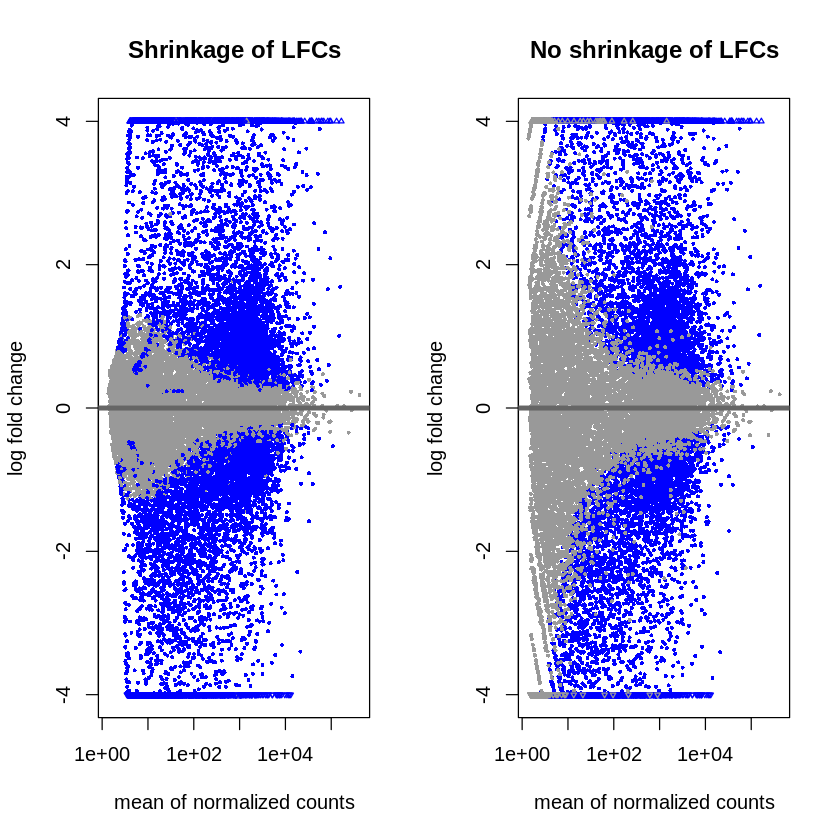

In [8]:
# The shrinkage of effect size (LFC) helps to remove the low count genes (by shrinking towards zero). 
resLFC <- lfc_shrink(dds)

# Visualize the shrinkage estimation of LFCs with MA plot and compare it without shrinkage of LFCs,
MA_plots(res, resLFC)

### PCA (Principal Component Analysis) plot

PCA (Principal Component Analysis) plots are commonly used in the analysis of gene expression data to provide an overview of the structure and variation in the dataset. PCA is a dimensionality reduction technique that transforms the data into a new coordinate system such that the greatest variance lies on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.

In the context of differential expression analysis, PCA plots help in several ways:

1. **Sample Clustering**: By plotting the samples on the first few principal components, you can see if samples from the same conditions or groups tend to cluster together. This is often taken as a sign that the major sources of variation in the data are biologically meaningful.

2. **Identifying Outliers**: PCA plots can help in identifying outlier samples that do not cluster with any group. These outliers might be due to technical errors or unaccounted biological variation and might need further investigation.

3. **Visualizing Batch Effects**: Sometimes, non-biological factors, such as the day of experiment or technician, can introduce systematic variation in the data. PCA plots can be used to see if there is batch effect present - for instance, if all samples processed on a certain day cluster together regardless of their biological group.

4. **Assessing the Importance of Principal Components**: The proportion of the total variance that is captured by each principal component is often indicated in a PCA plot. If a large proportion of the variance is captured by the first few principal components and these separate the samples according to the relevant biological groups, this can be an indication that the data have strong signal relative to noise.

5. **Determining Complexity of the Data**: If the samples do not cluster clearly on the first two or three principal components, this may suggest that the data has a complex structure, with no single factor accounting for a large proportion of the variance. This might indicate that more sophisticated methods are necessary for analysis.

6. **Assisting in Data Quality Assessment**: PCA can also be used in initial stages of data quality assessment, before differential expression analysis. It can provide insights on whether the sample grouping follows the expected pattern based on experimental design.

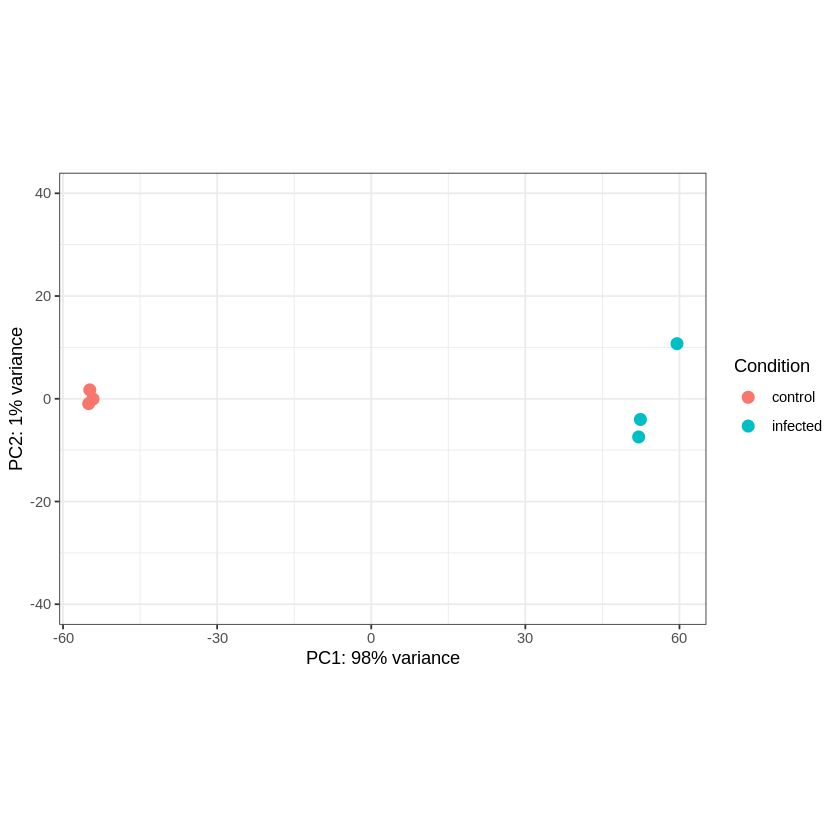

In [9]:
PCA_plot(dds)

### Volcano plot

Volcano plots are a type of scatter plot that is commonly used to visualize the results of differential expression analyses, particularly in genomics. The plot helps in simultaneously displaying the statistical significance and magnitude of change between two biological conditions for thousands of genes.

In a volcano plot:

- The x-axis typically represents the log2 fold change between two conditions. This means genes to the right of the center have higher expression in the first condition, whereas genes to the left have lower expression.

- The y-axis represents the negative logarithm (usually base 10) of the p-value, which indicates the statistical significance of the expression difference. The higher on the plot, the more statistically significant the change is.

This combination allows the plot to show both the magnitude of the change (fold change) and the significance level (p-value) in a single view.

Volcano plots help in several ways:

1. **Highlighting Significantly Differentially Expressed Genes**: Genes that are highly differentially expressed and have high statistical significance appear in the upper left and upper right corners of the plot. These genes are often the most biologically interesting.

2. **Visualizing the Distribution of p-values and Fold Changes**: The plot provides a global view of the relationship between fold changes and their statistical significance across all genes.

3. **Identifying Candidates for Further Investigation**: Researchers often look for genes in the upper part of the plot (significant) with large fold changes (left or right) as candidate genes for further biological investigation.

4. **Assessing the Quality of the Differential Expression Analysis**: If the volcano plot shows a reasonable number of genes with high significance and high fold change, it may suggest that the experimental design and data analysis were able to detect biologically relevant changes.

5. **Setting Custom Thresholds**: Often, horizontal and vertical lines are added to indicate custom thresholds for significance and fold change, making it easy to visually identify genes that meet these criteria.

6. **Gene Annotations**: Sometimes the points in the plot are annotated with gene names, especially for those that are highly significant and have large fold changes, to immediately see which genes are the most interesting candidates.

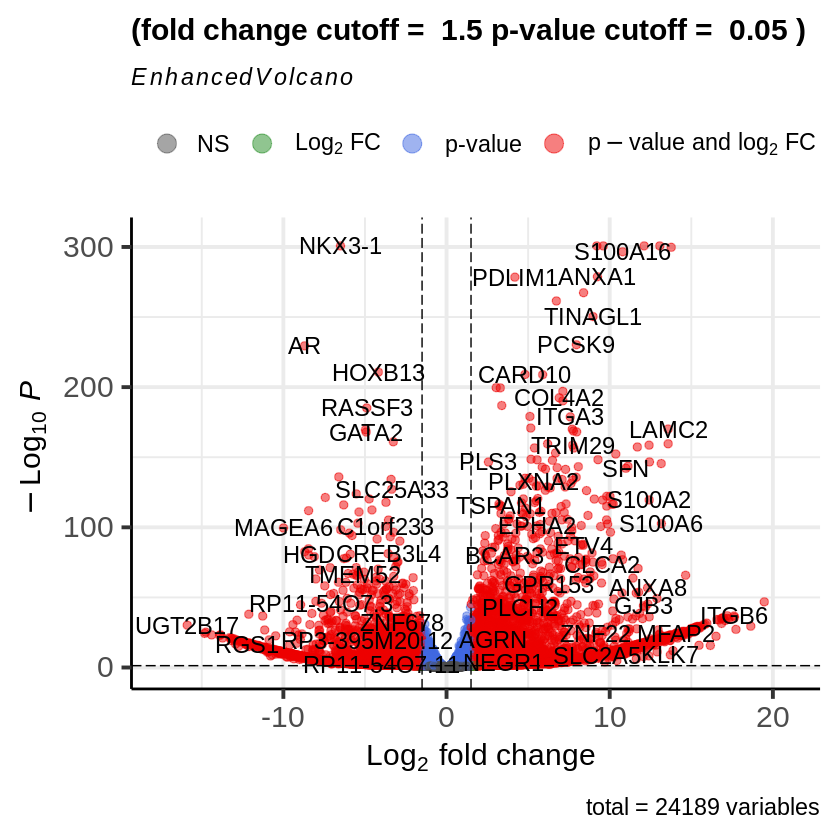

In [10]:
volcano_plot(resLFC, p_value_cutoff=p_value_cutoff, logFC_cutoff=logFC_cutoff)

### Heatmap plots

Heatmap plots are commonly used in the visualization of gene expression data, especially in the context of differential expression analysis. A heatmap displays a matrix of numerical data where individual values are represented as colors. In the context of gene expression, rows usually represent genes and columns represent samples, and the color represents the expression level of each gene in each sample.

Here is what heatmaps help to show during differential expression analysis:

1. **Expression Patterns Across Samples**: Heatmaps can be used to visualize how the expression levels of a set of genes vary across different samples. This can help in identifying groups of genes that are co-expressed across the samples.

2. **Sample Clustering**: Often, heatmaps are accompanied by a dendrogram (tree diagram) along the columns, which groups samples based on the similarity of their expression profiles. This can reveal natural groupings or clusters within the samples, often corresponding to biological conditions or phenotypes.

3. **Gene Clustering**: Similarly, a dendrogram can also be used along the rows to group genes that have similar expression patterns across the samples. This can identify sets of genes that might be co-regulated or involved in the same biological processes.

4. **Visualizing Differentially Expressed Genes**: Heatmaps are often used to display the expression patterns of a subset of genes that were identified as differentially expressed. This allows for the visualization of how these genes' expression patterns differ across conditions.

5. **Functional Enrichment Insights**: By clustering genes with similar expression patterns, you might find that clusters are enriched in genes with certain functions or pathways. This can be biologically informative.

6. **Data Quality and Batch Effects**: By looking at the clustering of samples, you might also identify unexpected clustering that could be due to batch effects or data quality issues.

7. **Exploration of Expression Dynamics**: In experiments with time-series data or gradients (such as dosage), heatmaps can help in understanding the dynamics of gene expression changes.

8. **Interaction and Correlation Patterns**: In multi-factor experiments, heatmaps can be used to understand interaction effects between factors (e.g., genotype and environment) on gene expression.

HTML widgets cannot be represented in plain text (need html)

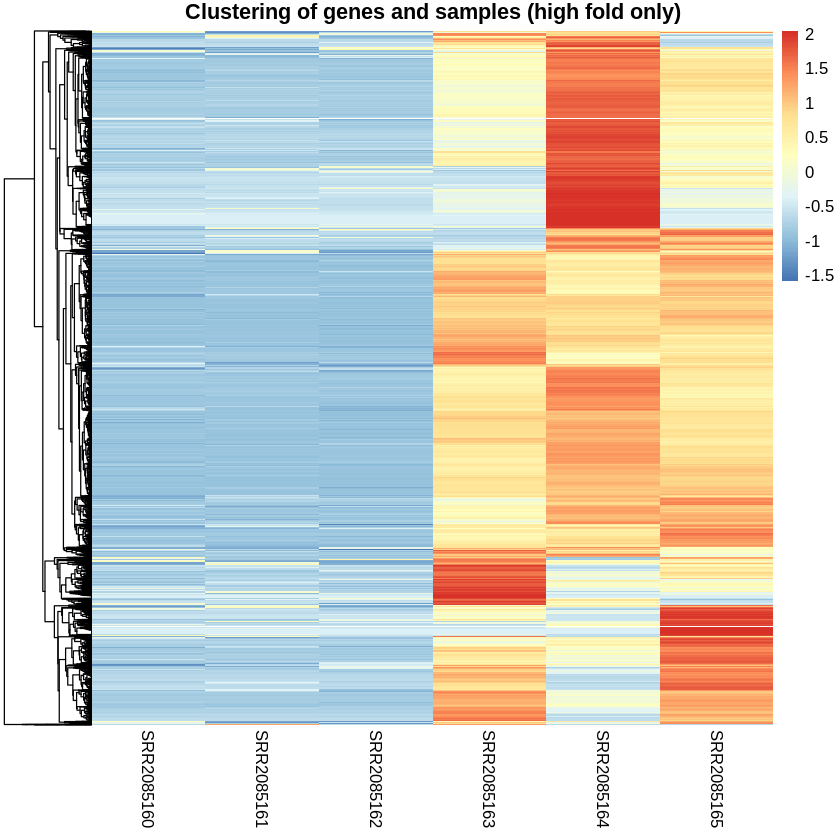

In [11]:
counts_scaled_filtered_high_fold_change = heatmap_plot(normalized_counts, logFC_cutoff)
display_table(table = counts_scaled_filtered_high_fold_change, caption = "Table 3: Heatmap Input (scaled, filtered, high-fold change)")

# Geneset Enrichment Analysis 

Gene set enrichment analysis (GSEA) is a method used to identify classes of genes or proteins that are over-represented in a large set of genes or proteins and may have an association with disease phenotypes. The method uses statistical approaches to identify significantly enriched or depleted groups of genes. 

`gseGO` is a specific function within the `clusterProfiler` R package that performs gene set enrichment analysis for Gene Ontology (GO) terms. Gene Ontology is a major bioinformatics initiative that aims to standardize the representation of gene and gene product attributes across species and databases. GO terms are categorized into three groups: Biological Process, Molecular Function, and Cellular Component.

Here is what `gseGO` hopes to accomplish in RNAseq data:

1. **Biological Interpretation**: By using `gseGO`, researchers can interpret the biological themes among a list of differentially expressed genes. It helps to understand what types of biological processes, molecular functions, or cellular components are enriched among the genes that are differentially expressed.

2. **Reducing Complexity**: RNA-seq can generate a list of thousands of differentially expressed genes. `gseGO` helps to summarize this list into a set of enriched GO terms, making it easier to understand the underlying biology.

3. **Hypothesis Generation**: By identifying GO terms that are significantly enriched, researchers can generate hypotheses for further experimental validation. For example, if a particular biological process is enriched, one might hypothesize that this process is critical in the condition being studied.

4. **Identifying Key Pathways and Processes**: Knowing which GO terms are enriched can provide insight into the key pathways and processes that are active or disrupted under the studied conditions.

5. **Understanding Mechanisms of Disease or Treatment**: In the context of disease or drug studies, understanding the enriched GO terms can shed light on the mechanisms by which a disease develops or how a particular treatment is exerting its effects.

6. **Functional Classification of Novel Genes**: For newly discovered genes or genes with unknown functions, observing their co-enrichment with well-studied genes under particular GO terms can provide hints regarding their potential functions.

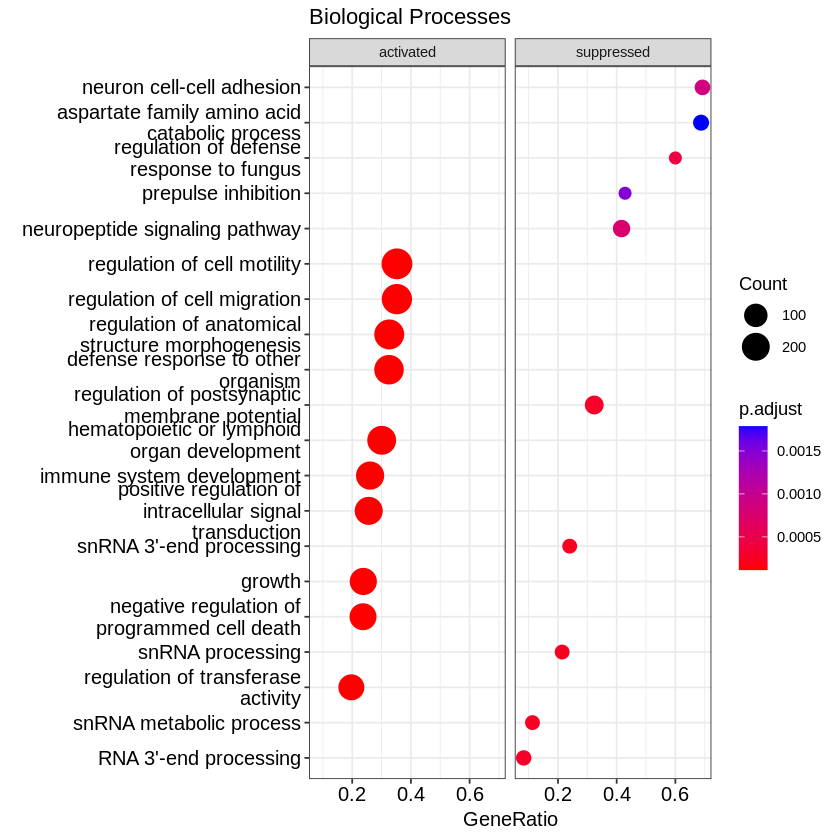

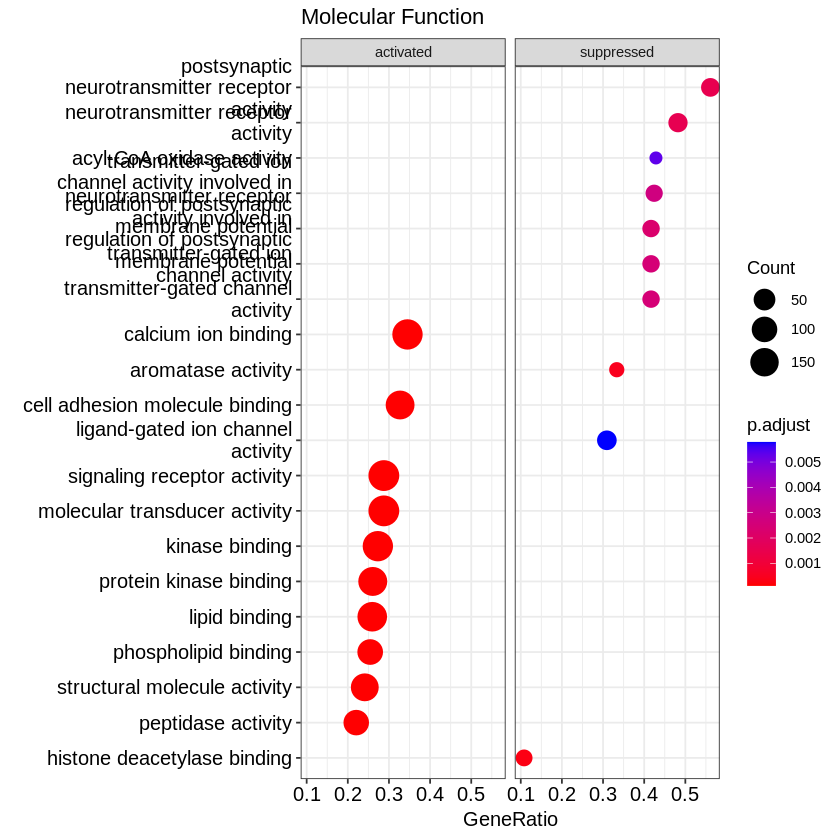

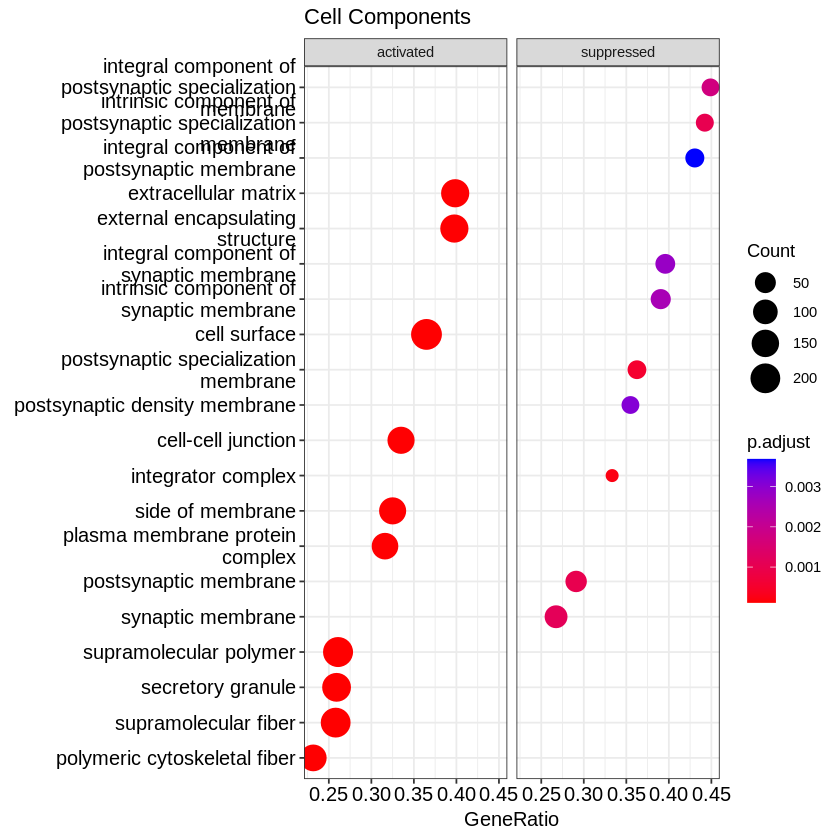

In [12]:
# Run Gene Enrichment Analysis
gseGO_results = run_gseGO(res, organism, p_value_cutoff)
plot_gseGO(gseGO_results)

In addition to the plots displayed here, emap plots are also produced. These plots help visualize gene sets as a network (i.e. enrichment map). Mutually overlapping gene sets tend to cluster together, making it easier for interpretation. For more information please see: https://rdrr.io/bioc/enrichplot/man/emapplot.html 

Results can be found in the `results` directory

# Pathway Analysis

Pathway analysis methods such as `gseKEGG` (for KEGG pathways), `gsePathway` (for reactome), and `gseWP` (for WikiPathways) within the `clusterProfiler` R package, are designed to perform gene set enrichment analysis on biological pathways. These functions use statistical approaches to determine if sets of genes involved in known biological pathways are significantly enriched or depleted among a list of differentially expressed genes from RNA-seq data.

Here's what these pathway analyses aim to accomplish:

1. **Biological Context**: Pathway analysis provides biological context to the list of differentially expressed genes by identifying which biological pathways are being affected. This is essential for understanding the underlying biology of the experimental conditions being studied.

2. **Functional Insight**: By identifying enriched pathways, the analysis can provide functional insight into how changes in gene expression may contribute to phenotypic differences. For instance, understanding which metabolic or signaling pathways are altered can provide clues about the mechanisms of a disease or a drug's action.

3. **Data Reduction and Summarization**: RNA-seq experiments often result in a long list of differentially expressed genes, which can be difficult to interpret. Pathway analysis helps to summarize this list into a smaller number of meaningful biological pathways, making the results more interpretable.

4. **Hypothesis Generation**: Identifying enriched pathways can help generate new hypotheses for experimental validation. For instance, if a pathway is enriched that was not previously known to be involved in the condition being studied, this could be a basis for further investigation.

5. **Identification of Therapeutic Targets**: In the context of disease studies, pathway analysis can help identify key pathways that are disrupted in disease states. These pathways may contain potential targets for therapeutic intervention.

6. **Biological Classification of Novel Genes**: For genes with unknown functions, knowing the pathways in which they are enriched can provide information about their potential roles in cellular processes.

7. **Integration of Multi-Omics Data**: Sometimes pathway analyses are used in the context of integrating data from different sources (e.g., proteomics, metabolomics) alongside RNA-seq data, to provide a more comprehensive view of the biological system.

8. **Understanding Pathway Cross-Talk**: Enrichment in certain pathways can suggest how different pathways might interact or affect each other, which is sometimes called pathway cross-talk.

- **gseKEGG**: Focuses on KEGG (Kyoto Encyclopedia of Genes and Genomes) pathways, which is a database resource for understanding high-level functions and utilities of the biological system.

- **gseWP**: Focuses on WikiPathways, which is an open, collaborative platform dedicated to the curation of biological pathways by and for the scientific community.

- **gsePathway**: Is a more general term and can refer to the analysis involving various pathway databases.

In summary, pathway analysis in RNA-seq data is crucial for converting the gene-level information into a higher-level understanding of the biological processes and pathways that are active or altered under the conditions being studied. This helps in interpreting the data in a biologically meaningful way.

'select()' returned 1:many mapping between keys and columns



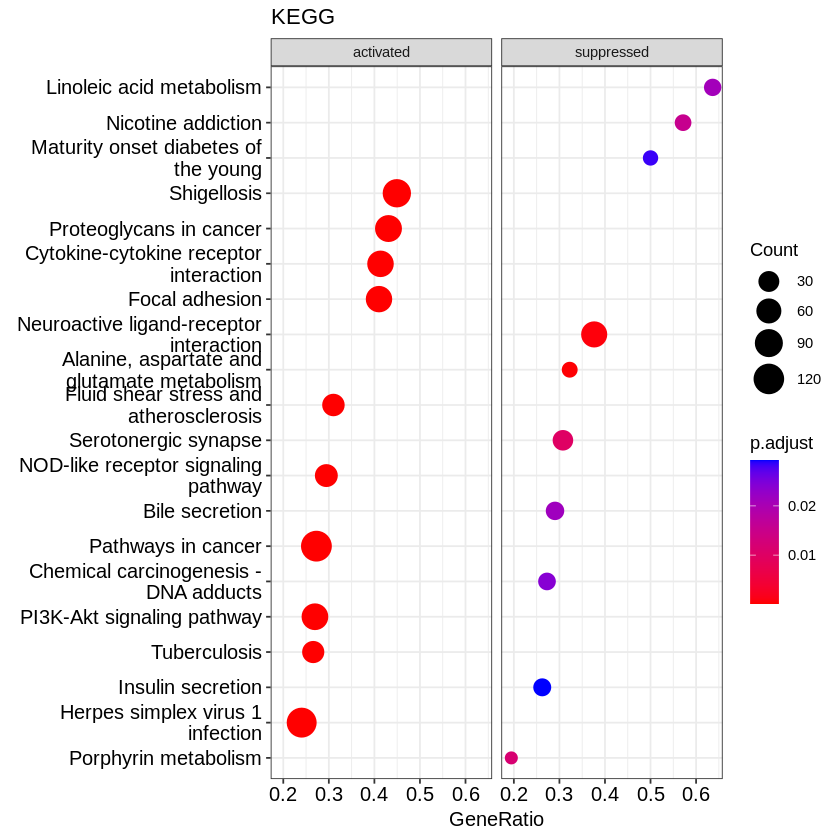

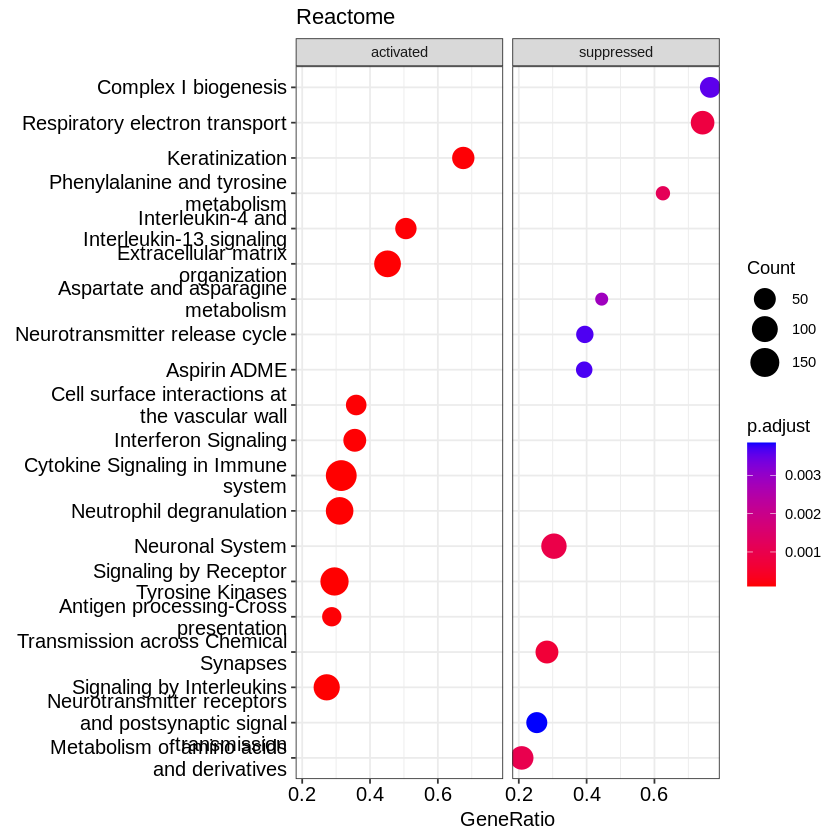

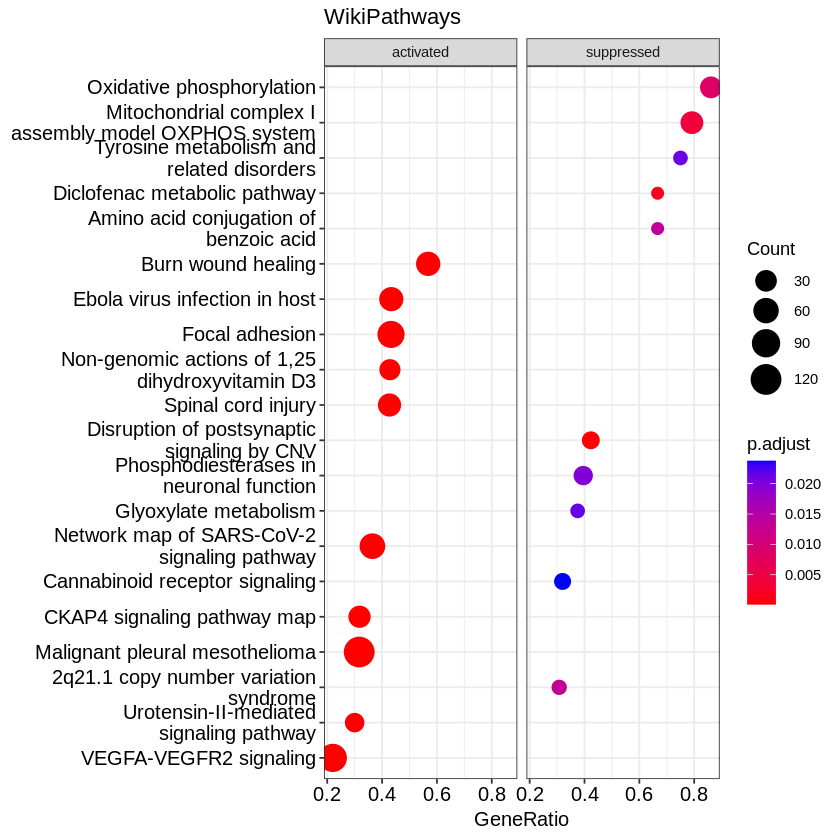

In [13]:
# Run Pathway Analysis
gseKEGG_results = run_gseKEGG(gseGO_results$original_gene_list, organism, kegg_organism, reactome_organism, wikiPathways_organism, p_value_cutoff)
plot_gseKEGG(gseKEGG_results) 

In addition to the plots displayed here, emap plots are also produced. These plots help visualize gene sets as a network (i.e. enrichment map). Mutually overlapping gene sets tend to cluster together, making it easier for interpretation. For more information please see: https://rdrr.io/bioc/enrichplot/man/emapplot.html 

Results can be found in the `results` directory

### pathview

The `pathview` package in R is designed for data integration and visualization of pathway analysis. Through this integration, it aids in the biological interpretation of gene expression data, metabolomic data, and other high throughput data. The main features and accomplishments of the `pathview` package include:

1. **Pathway-Based Data Visualization**: `pathview` maps and renders a wide range of biological data on relevant pathway graphs. Users can input gene or metabolite data, and the package will map these data onto pathway diagrams.

2. **Integration with KEGG**: The package integrates tightly with the KEGG (Kyoto Encyclopedia of Genes and Genomes) database, which is a comprehensive database resource that integrates genomic, chemical and systemic functional information. `pathview` downloads the pathway diagrams and data directly from KEGG and renders data on top of them.

3. **Dual Data Visualization**: One of the unique features of `pathview` is its capability to visualize both gene and compound data simultaneously in the context of the same pathway.

4. **Customization and Flexibility**: `pathview` provides a range of options for data visualization. Users can control colors, data categories, and graphical parameters to generate customized pathway diagrams that highlight aspects of the data they are most interested in.

5. **Multi-Layer Data Visualization**: The package can render multiple datasets (e.g. time course, dose-response, or data from different omics platforms) onto the same pathway, which is useful for comparisons.

6. **Graphical and Text Output**: `pathview` generates pathway diagrams in various graphical formats (such as PNG, PDF, SVG) and also supports pathway data output in plain text format.

7. **Automated Analysis and Visualization**: The package can be used for automated, high-throughput pathway analysis and visualization. This is useful in scenarios where you need to analyze many pathways or large datasets.

8. **Enhancing Interpretation of Pathway Analysis**: By visually mapping data onto biological pathways, `pathview` helps users to interpret pathway analysis results in a biological context, which is essential for hypothesis generation and experimental design.

**Note** Currently only support KEGG pathways for visualizations. Results of this can be found under `results/kegg`

In [ ]:
pathview_plots(gseKEGG_results$kegg_gene_list, kegg_organism, gseKEGG_results$kegg, num_hits=10)